In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py


In [44]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

In [45]:
import sys
# Import FBP
sys.path.append('../FBPConvNet/')
from FBPConvNet import Generator, Discriminator2

sys.path.append('../')
from net_utils import get_datetime

In [46]:
from pix2pixModels import UnetGenerator,NLayerDiscriminator

# Generate Example Data

In [47]:
def preprocess(data):
    return torch.Tensor(data).unsqueeze(1)
def target_ones(N,gpu=False):
    if GPU:
        return torch.ones(N,1).cuda()
    else:
        return torch.ones(N,1)
def target_zeros(N,gpu=False):
    if GPU:
        return torch.zeros(N,1).cuda()
    else:
        return torch.zeros(N,1)   

In [6]:
# set path to data
pathtodata = '../data/NormRandomLineEllipses15.hdf5'
dataset_size = 200
batch_size = 1

In [7]:
f = h5py.File(pathtodata,'r')
print([ key for key in f['ellip']])
fakeinput = preprocess(f['ellip/training_data'][0:dataset_size])
fakelabels = preprocess(f['ellip/training_labels'][0:dataset_size])
reallabels = preprocess(f['ellip/training_labels'][dataset_size:2*dataset_size])

testinput = preprocess(f['ellip/test_data'])
testlabels = preprocess(f['ellip/test_labels'])
f.close()

['test_data', 'test_labels', 'training_data', 'training_labels']


In [ ]:
# f = h5py.File(pathtodata,'r')
# print([ key for key in f['ellip']])

# fakeinput1 = f['ellip/training_data'][0:dataset_size]
# fakeinput2 = fakeinput1.copy()[:,:,::-1]
# fakeinput = preprocess(np.concatenate((fakeinput1,fakeinput2)))

# fakelabels1 = f['ellip/training_labels'][0:dataset_size]
# fakelabels2 = fakelabels1.copy()[:,:,::-1]
# fakelabels = preprocess(np.concatenate((fakelabels1,fakelabels2)))

# reallabels1 = f['ellip/training_labels'][dataset_size:2*dataset_size]
# reallabels2 = reallabels1.copy()[:,:,::-1]
# reallabels = preprocess(np.concatenate((reallabels1,reallabels2)))

# del fakeinput1, fakeinput2, fakelabels1, fakelabels2, reallabels1, reallabels2

# # testinput = preprocess(f['ellip/test_data'])
# # testlabels = preprocess(f['ellip/test_labels'])
# f.close()

In [ ]:
def normalize(img,center=None,multval=None):
    # Adjust image to be -1 to 1
    # Move center of range to 0
    # stretch
    if center != None and multval != None:
        # both exist, normalize using existing values
        img -= center
        img /= multval
        return img
    else:
        center = (img.max() + img.min())/2
        multval = (img-center).max()
        return (img-center)/multval, center, multval

In [ ]:
# f = h5py.File('../data/bigNormRandomLineEllipses15.h5py','r')
# g = h5py.File('../data/NormRandomLineEllipses15.hdf5','a')

# for group in f.keys():
#     for dataset in f[group]:
#         key = group+'/'+dataset
#         print(key)
#         g.create_dataset(key,data=f[key],compression='gzip')
# g.close()
        
# f.close()


In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(fakeinput[-1,0])
plt.subplot(122)
plt.imshow(fakelabels[-1,0])

In [8]:
faketrainset = TensorDataset(fakeinput,fakelabels)
testset = TensorDataset(testinput,testlabels)

faketrainloader = DataLoader(faketrainset,batch_size=batch_size,shuffle=True)
realtrainloader = DataLoader(reallabels, batch_size=batch_size,shuffle=True)
testloader = DataLoader(testset,batch_size=1,shuffle=False)

# Plot Training Loss

In [303]:
basepath = './experiments/ShortExperiments/Lambda10/'

In [304]:
# Epoch	D Loss	G Loss	Epoch Time	Total Time

In [305]:
loss = np.loadtxt(basepath+'log.txt',skiprows=1,usecols=(0,1,2), delimiter='\t' ,dtype=float)

In [306]:
d_losses = loss[:,1]
g_losses = loss[:,2]

Text(0.5,1,'Generator Losses')

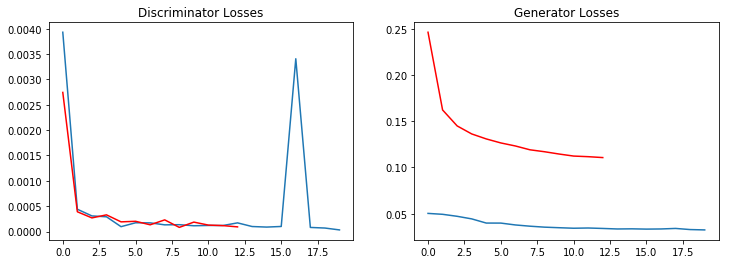

In [307]:
start = 0
end = len(d_losses)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(start,end),d_losses[start:end])
plt.plot(d_losses1,'r')
plt.title('Discriminator Losses')
plt.subplot(122)
plt.plot(np.arange(start,end),g_losses[start:end])
plt.plot(g_losses1,'r')
plt.title('Generator Losses')

# Visualize Examples

In [308]:
#G = Generator()
G = UnetGenerator(input_nc=1, output_nc=1, num_downs=8, ngf=64, norm_layer=nn.InstanceNorm2d, use_dropout=True)
GPU = torch.cuda.is_available()
print('Using GPU:',GPU)

Using GPU: True


In [309]:
#weightspath = '../FBPConvNet/weights/2018-05-07_14-50-41/epoch_500.weights'
#basepath = './experiments/6_GANs_AugmentedData/'
weightspath = basepath+'G_epoch_20.weights'
print(weightspath)
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)
if GPU:
    G = G.cuda()

./experiments/ShortExperiments/Lambda10/G_epoch_20.weights


In [310]:
testiter = iter(testloader)

D:\Anaconda3\envs\pytorch\lib\site-packages\ipykernel\__main__.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


(-0.5, 255.5, 255.5, -0.5)

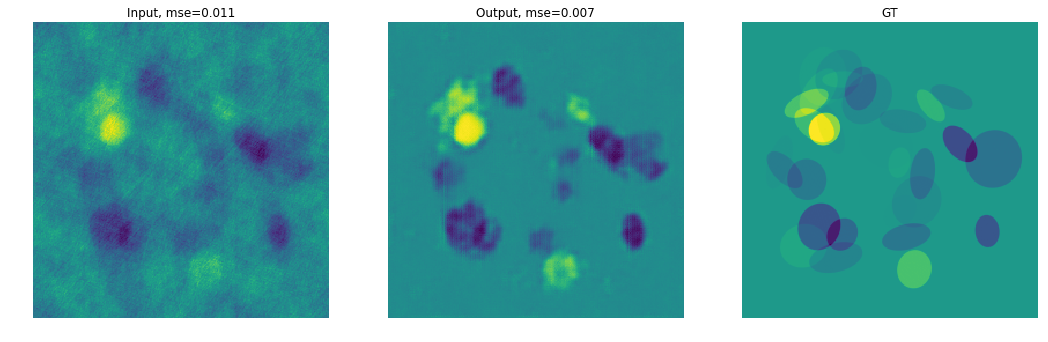

In [313]:
y,x = testiter.next()
G.eval()
GPU = True
if GPU:
    xhat = G(Variable(y.cuda(),volatile=True))
    xhat = xhat.cpu().data
else:
    xhat = G(Variable(y)).data
plt.figure(figsize=(18,6))
plt.subplot(131)
mse =torch.mean((y[0,0,:,:]-x[0,0,:,:])**2)
plt.imshow(y[0,0,...].numpy())
plt.title('Input, mse=%.3f'%(mse))
plt.axis('off')

mse =torch.mean((xhat[0,0,:,:]-x[0,0,:,:])**2)
plt.subplot(132)
plt.imshow(xhat[0,0,...].numpy())
plt.title('Output, mse=%.3f'%(mse))
plt.axis('off')

plt.subplot(133)
plt.imshow(x[0,0,...].numpy())
plt.title('GT')
plt.axis('off')

# Compute Average MSE

In [ ]:
def test_mse(G, testloader):
    # Calculate Test MSE
    test_mses = np.zeros(len(testloader))
    for i,data in enumerate(testloader):
        y,x = data 
        GPU = True
        if GPU:
            xhat = G(Variable(y.cuda(),volatile=True))
            xhat = xhat.cpu().data
        else:
            xhat = G(Variable(y,volatile=True)).data

        test_mses[i] = torch.mean((xhat[:,0,:,:]-x[:,0,:,:])**2)
    return test_mses.mean()

In [ ]:
mse = test_mse(G,testloader)
print('Test MSE = %f'%(mse))

In [ ]:
nums = range(0,300,25)
len(nums), nums[-1]

In [ ]:
mses = np.zeros(len(nums)+1)
train_mses = np.zeros(len(nums)+1)

G_basepath = basepath + 'G_epoch_'

for i,epoch in enumerate(nums):
    weightspath = G_basepath + str(epoch+1) + '.weights'
    checkpoint = torch.load(weightspath)
    G.load_state_dict(checkpoint)
    G = G.cuda()
    mses[i] = test_mse(G,testloader)
    train_mses[i] = test_mse(G,faketrainloader)

weightspath = G_basepath + str(300) + '.weights'
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)
G = G.cuda()
mses[-1] = test_mse(G,testloader)
train_mses[-1] = test_mse(G,faketrainloader)


In [ ]:
plt.figure()
#plt.plot(nums,mses)
epochs = range(0,301,25)
plt.plot(epochs,mses,label='Test MSE')
plt.plot(epochs,train_mses,label='Train MSE')
plt.legend(loc=0)

print('Test:',mses[-1],mses.min())
print('Train:',train_mses[-1],train_mses.min())

# Test Discriminator

In [ ]:
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        # Input 1 x 256 x 256 -> 64 x 128 x 128
        self.conv1 = nn.Conv2d(1,64,3,padding=1,stride=2)
        self.batch1 = nn.BatchNorm2d(64)

        # -> 128 x 64 x 64
        self.conv2 = nn.Conv2d(64,128,7,padding=3,stride=2)
        self.batch2 = nn.BatchNorm2d(128)

        # -> 256 x 32 x 32 -> 256 x 16 x 16
        self.conv3 = nn.Conv2d(128,256,5,padding=2,stride=2)
        self.batch3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,256,7,padding=3,stride=2)
        self.batch4 = nn.BatchNorm2d(256)

        # -> 512 x 8 x 8
        self.conv5 = nn.Conv2d(256,512,5,padding=2,stride=2)
        self.batch5 = nn.BatchNorm2d(512)

        # -> 1024 x 1 x 1
        self.conv6 = nn.Conv2d(512,1024,5,padding=2,stride=2)
        self.batch6 = nn.BatchNorm2d(1024)
        self.conv7 = nn.Conv2d(1024,1024,3,padding=1,stride=2)
        self.batch7 = nn.BatchNorm2d(1024)

        self.conv8 = nn.Conv2d(1024,1024,3,padding=1,stride=2)
        self.batch8 = nn.BatchNorm2d(1024)

        self.conv9 = nn.Conv2d(1024,1024,3,padding=1,stride=2)

        # Decision layers
        self.d_conv1 = nn.Conv2d(1024,1024,2)
#         self.d_conv2 = nn.Conv2d(1024,1024,1)
        self.d_conv3 = nn.Conv2d(1024,1,1)

        # Non-Linear Activations
        self.leaky = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv2_drop = nn.Dropout2d(p=.2)
  
    def forward(self,x):
        # Generate Features
        x = self.leaky(self.conv1(x))
        x = self.leaky(self.batch2(self.conv2(x)))
        x = self.leaky(self.batch3(self.conv3(x)))
        x = self.leaky(self.batch4(self.conv4(x)))
        x = self.leaky(self.batch5(self.conv5(x)))
        x = self.leaky(self.batch6(self.conv6(x)))
        x = self.leaky(self.batch7(self.conv7(x)))
        #x = self.leaky(self.batch8(self.conv8(x)))
        #x = self.leaky(self.conv9(x))

        # Decision Layers
        x = self.leaky(self.conv2_drop(self.d_conv1(x)))
        x = self.sigmoid(self.d_conv3(x))
        return x


In [ ]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=1024, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*8*8, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*8*8)
        x = self.out(x)
        return x

In [ ]:
def test_D_accuracy(D,G, faketrainloader, realtrainloader,GPU=True):
    # assumes batchsize 1 for now
    flen = len(faketrainloader)
    rlen = len(realtrainloader)
    gt = np.zeros(flen+rlen)
    gt[flen:] = 1
    
    predictions = np.zeros(flen + rlen)
    for i,data in enumerate(faketrainloader):
        input_, label = data
        input_ = input_.cuda()
        pred = D(G(Variable(input_,volatile=True)))
        predictions[i] = pred.data.mean()

    for i,input_ in enumerate(realtrainloader,flen):
        input_ = input_.cuda()
        pred = D(Variable(input_,volatile=True))
        predictions[i] = pred.data.mean()
        
    final = predictions.copy()
    final[final < .5] = 0
    final[final > .5] = 1

    return np.sum(np.abs(final - gt))/(rlen+flen), predictions



In [244]:
dpath = basepath + 'D_epoch_11.weights'
D = NLayerDiscriminator(1,n_layers=4,use_sigmoid=False)
checkpoint = torch.load(dpath)
D.load_state_dict(checkpoint)
GPU = True
if GPU:
    D = D.cuda()

In [ ]:
nums = np.arange(0,300,25)
d_accuracy = np.zeros(len(nums)+1)

D_basepath = basepath + 'D_epoch_'

for i,epoch in enumerate(nums):
    weightspath = D_basepath + str(epoch+1) + '.weights'
    checkpoint = torch.load(weightspath)
    D.load_state_dict(checkpoint)
    D = D.cuda()
    acc,pred = test_D_accuracy(D,G,faketrainloader,realtrainloader)
    d_accuracy[i] = acc

weightspath = D_basepath + str(300) + '.weights'
checkpoint = torch.load(weightspath)
D.load_state_dict(checkpoint)
D = D.cuda()
acc,pred = test_D_accuracy(D,G,faketrainloader,realtrainloader)
d_accuracy[-1] = acc

In [ ]:
plt.plot(np.append(nums,300),d_accuracy)
plt.ylabel('Percent Error')
plt.xlabel('Epoch')

In [ ]:
weightspath = basepath+'G_epoch_51.weights'
print(weightspath)
checkpoint = torch.load(weightspath)
G.load_state_dict(checkpoint)
if GPU:
    G = G.cuda()

In [281]:
dpath = basepath + 'D_epoch_20.weights'
D = NLayerDiscriminator(1,n_layers=4, use_sigmoid=False)
checkpoint = torch.load(dpath)
D.load_state_dict(checkpoint)
D = D.cuda()

In [282]:
gt = np.zeros(400)
gt[200:] = 1

In [283]:
predictions = np.zeros(400)
for i,data in enumerate(faketrainloader):
    input_, label = data
    input_ = input_.cuda()
    with torch.no_grad():
        pred = D(G(input_))
#    pred = D(Variable(input_,volatile=True))
    predictions[i] = pred.data.mean()
    
for i,input_ in enumerate(realtrainloader,200):
    input_ = input_.cuda()
    with torch.no_grad():
        pred = D(input_)
    predictions[i] = pred.data.mean()
    


0.495


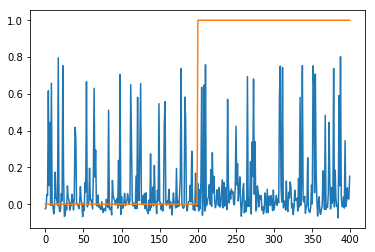

In [284]:
final = predictions.copy()
final[final < .5] = 0
final[final > .5] = 1
plt.plot(predictions)
plt.plot(gt)
#plt.plot(final)
print(np.sum(np.abs(final - gt))/400)

In [256]:
print(final.sum())

17.0


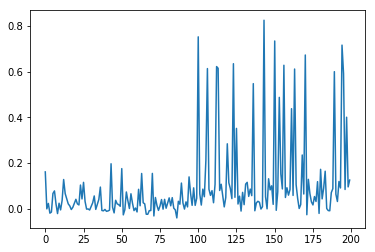

In [251]:
test_predictions = np.zeros(2*len(testloader))
for i,data in enumerate(testloader):
    input_, label = data
    input_ = input_.cuda()
    
    with torch.no_grad():
        pred = D(G(input_))
    test_predictions[i] = pred.data.mean()
    
    label = label.cuda()
    with torch.no_grad():
        pred = D(label)
    test_predictions[i+len(testloader)] = pred.data.mean()

plt.figure()
plt.plot(test_predictions)

In [214]:
dpath = basepath + 'D_epoch_15.weights'
D = NLayerDiscriminator(1,n_layers=4, use_sigmoid=False)
checkpoint = torch.load(dpath)
D.load_state_dict(checkpoint)
D = D.cuda()

In [176]:
testiter = iter(faketrainloader)

torch.Size([1, 1, 15, 15])


(-0.5, 255.5, 255.5, -0.5)

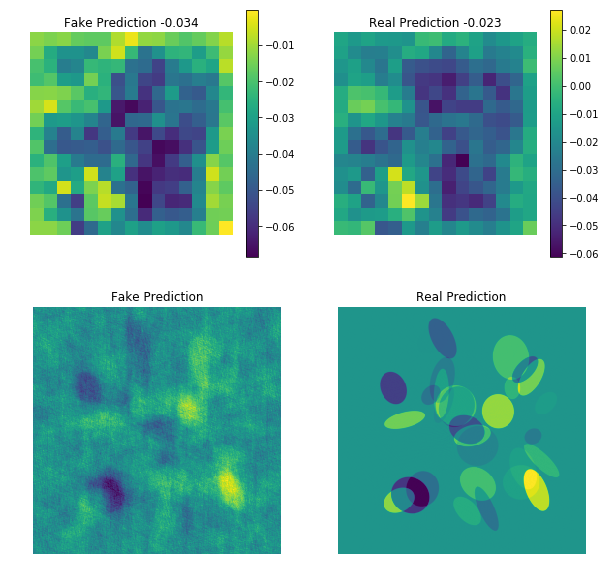

In [221]:
input_, label = testiter.next()
input_ = input_.cuda()
label = label.cuda()
with torch.no_grad():
    fakepred = D(G(input_))
    realpred = D(label)
print(fakepred.shape)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(fakepred[0,0,...].cpu().numpy())
plt.title('Fake Prediction %.3f' % (fakepred.mean()))
plt.axis('off')
plt.colorbar()

plt.subplot(222)
plt.imshow(realpred[0,0,...].cpu().numpy())
plt.title('Real Prediction %.3f'%(realpred.mean()))
plt.axis('off')
plt.colorbar()

plt.subplot(223)
plt.imshow(input_[0,0,...].cpu().numpy())
plt.title('Fake Prediction')
plt.axis('off')


plt.subplot(224)
plt.imshow(label[0,0,...].cpu().numpy())
plt.title('Real Prediction')
plt.axis('off')

In [91]:
loss = nn.MSELoss()
a = torch.rand(1,1,20,20)
b = torch.rand(1,1,20,20)

In [96]:
loss(a,b).item()

0.15554112195968628

# Ignore 

In [286]:
basepath = '../data/facades/train/'


In [294]:
for i in range(1,401):
    img = plt.imread(basepath+str(i)+'.jpg')
    if img.shape != (256,512,3):
        print(img.shape)

In [290]:
label = img[:,:256,:]
img = img[:,256:,:]

In [300]:
from PIL import Image
import random
from torch.utils.data import Dataset, DataLoader

class FacadeDataset(Dataset):
    def __init__(self,basepath):
        self.basepath = basepath
        self.imagepaths = [self.basepath + str(num)+'.jpg' for num in range(1,401)]
    
    def __getitem__(self,index):
        img = Image.open(self.imagepaths[index]).convert('RGB')
        w,h = img.size
        w2 = int(w/2)
        label = img.crop((0,0,w2,h)).resize((286,286),Image.BICUBIC)
        input_ = img.crop((w2,0,w,h)).resize((286,286),Image.BICUBIC)
        
        label = transforms.ToTensor()(label)
        input_ = transforms.ToTensor()(input_)
        
        # Crop
        maxcrop = 286-256-1 
        w_offset = random.randint(0,maxcrop)
        h_offset = random.randint(0,maxcrop)
        
        label = label[:,h_offset:h_offset+256,w_offset:w_offset+256]
        input_ = input_[:,h_offset:h_offset+256,w_offset:w_offset+256]
        
        # normalize
        label = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(label)
        input_ = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(input_)
        
        # Flip
        if random.random() < 0.5:
            idx = [i for i in range(256-1,-1,-1)]
            idx = torch.LongTensor(idx)
            label = label.index_select(2,idx)
            input_ = input_.index_select(2,idx)
        
        # Convert to Grey
        tmp = label[0, ...] * 0.299 + label[1, ...] * 0.587 + label[2, ...] * 0.114
        label = tmp.unsqueeze(0)
        
        tmp = input_[0, ...] * 0.299 + input_[1, ...] * 0.587 + input_[2, ...] * 0.114
        input_ = tmp.unsqueeze(0)
        
        return input_, label
    def __len__(self):
        return 400
        

In [302]:
facade = FacadeDataset(basepath)
img,label = facade[0]

img.size(),label.size()

(torch.Size([1, 256, 256]), torch.Size([1, 256, 256]))

In [ ]:
out = D(Variable(torch.rand(1,1,256,256),volatile=True))
out.size()

In [ ]:
def convblock(in_channels, out_channels, use_batch=False):
    model = [nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=4, 
            stride=2, padding=1, bias=False
        )]
    if use_batch:
        model += [nn.BatchNorm2d(out_channels)]
    model += [nn.LeakyReLU(0.2, inplace=True)]
    return nn.Sequential(*model)
def deconvblock(in_channels, out_channels,use_dropout=False, use_batch=False):
    model = [nn.ConvTranspose2d(in_channels, out_channels,
                                        kernel_size=4, stride=2,
                                        padding=1)]
    if use_batch:
        model += [nn.BatchNorm2d(out_channels)]
    if use_dropout:
        model += [nn.Dropout(.5)]
    model += [nn.ReLU(inplace=True)]
    return nn.Sequential(*model)
    
    
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator,self).__init__()
        # encoder
        use_batch = True
        self.conv1 = convblock(1,64)
        self.conv2 = convblock(64,128,use_batch)
        self.conv3 = convblock(128,256,use_batch)
        self.conv4 = convblock(256,512,use_batch)
        self.conv5 = convblock(512,512,use_batch)
        self.conv6 = convblock(512,512,use_batch)
        self.conv7 = convblock(512,512,use_batch)
        self.conv8 = convblock(512,512)
        # decoder
        use_dropout = True
        

        # decoder
        self.deconv1 = deconvblock(512,512,use_dropout=use_dropout)
        self.deconv2 = deconvblock(1024,512,use_dropout=use_dropout,use_batch=use_batch)
        self.deconv3 = deconvblock(1024,512,use_dropout=use_dropout,use_batch=use_batch)
        self.deconv4 = deconvblock(1024,512,use_dropout=use_dropout,use_batch=use_batch)
        self.deconv5 = deconvblock(512,512,use_batch=use_batch)
        #self.deconv6 = deconvblock(512,256,use_batch=use_batch)

        
        #self.model = nn.Sequential(*model)
        
        
    def forward(self,x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)
        
        dx1 = self.deconv1(x8)
        dx2 = self.deconv2(torch.cat([dx1,x7],1))
        dx3 = self.deconv3(torch.cat([dx2,x6],1))
        dx4 = self.deconv4(torch.cat([dx3,x5],1))
        #dx5 = self.deconv5(torch.cat([dx4,x4],1))
        print(dx4.size(),x4.size())

        return dx4

In [ ]:
# Defines the Unet generator.
# |num_downs|: number of downsamplings in UNet. For example,
# if |num_downs| == 7, image of size 128x128 will become of size 1x1
# at the bottleneck
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        for i in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)

        self.model = unet_block

    def forward(self, input):
        return self.model(input)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost

        use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [ ]:
net = UnetGenerator(input_nc=1, output_nc=1, num_downs=8, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=True)
net(Variable(torch.rand(4,1,256,256))).size()

In [ ]:
plt.plot(np.arange(1,227,25),mses)

In [ ]:
print(mses[-1], mses.min())

In [ ]:
test_mses = np.zeros(len(testloader))

for i,data in enumerate(testloader):
    y,x = data 

    test_mses[i] = torch.mean((y[:,0,:,:]-x[:,0,:,:])**2)
print(test_mses.mean())

In [ ]:
G = G.cpu()
torch.save(G.state_dict(),'Gmse_100.weights')
D = D.cpu()
torch.save(D.state_dict(),'Dmse_100.weights')

if GPU:
    G = G.cuda()
    D = D.cuda()
